## Machine Learning methods for the Bike Sharing Demand Problem

Disclaimer: 
<br> This solution is showcased to share my understanding of the problem and my own approach to it.
<br> This solution is not intended for any general application.

#### For questions, suggestions and further details, please feel free to contact me at juan-carlos.ramirez@warwick.ac.uk

---------

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing
import sklearn.metrics as skmetrics
from sklearn import datasets, linear_model, svm
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
sns.set_theme() # Seaborn template
sns.set_palette(palette="crest") # Default colors
plt.rcParams['figure.figsize'] = [16, 8] # Default to bigger plots
pd.set_option('display.float_format', lambda x: '%.2f' % x) # display 2 decimals by default
rnd_seed = 42 # Random seed used across the notebook

------------

## Motivation

Our motivation in the present notebook will be to study the problem of Rental bikes, which is of major relevance to urban cities that seek to provide sustainable mobility alternatives to their population. We mainly follow the approach used by Sathishkumar et al. [1] who, by using weather information of the city of a metropolitan city, have the purpose of predicting the hourly demand of rental bikes.

-----------

## Data Exploration

First, by making use of the "SeoulBikeData_mod.csv" which contains the data of the first 6 months used by Sathishkumar et al. in their investigation, we explore the main statistical metrics of our resources to identify if there is any strange behaviour that we should turn our attention to, such as missing data or significant outliers.


In [2]:
# Step 1: Read the Data
BikeData = pd.read_csv("3.1 SVR vs LR Seoul bike demand data.csv") 
BikeData.describe()

,Rented Bike Count,Hour,Temperature(C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Month
count,4220.00,4220.00,4220.00,4220.00,4220.00,4220.00,4220.00,4220.00,4220.00,4220.00,4220.00
mean,665.80,11.52,9.48,54.73,1.88,1342.98,-0.07,0.61,0.10,0.06,3.49
std,652.25,6.93,11.19,20.99,1.08,622.58,12.44,0.91,0.96,0.35,1.72
min,20.00,0.00,-17.80,0.00,0.00,27.00,-30.60,0.00,0.00,0.00,1.00
25%,177.00,6.00,1.10,38.00,1.00,770.75,-9.80,0.00,0.00,0.00,2.00
50%,397.00,12.00,10.00,53.00,1.70,1495.00,0.60,0.02,0.00,0.00,3.00
75%,1020.25,18.00,19.10,70.00,2.60,1972.00,10.43,0.99,0.00,0.00,5.00
max,3556.00,23.00,32.70,98.00,7.40,2000.00,24.10,3.52,35.00,4.10,6.00


Here, we can quickly notice that there is no issue regarding missing data or outlier in our data. On the other hand, we can see that the variability of the Rented Bike Count is very significant, with a minimum and maximum value of 20 and 3,556 respectively.

Next, we make our data exploration deeper by making use of data visualization.

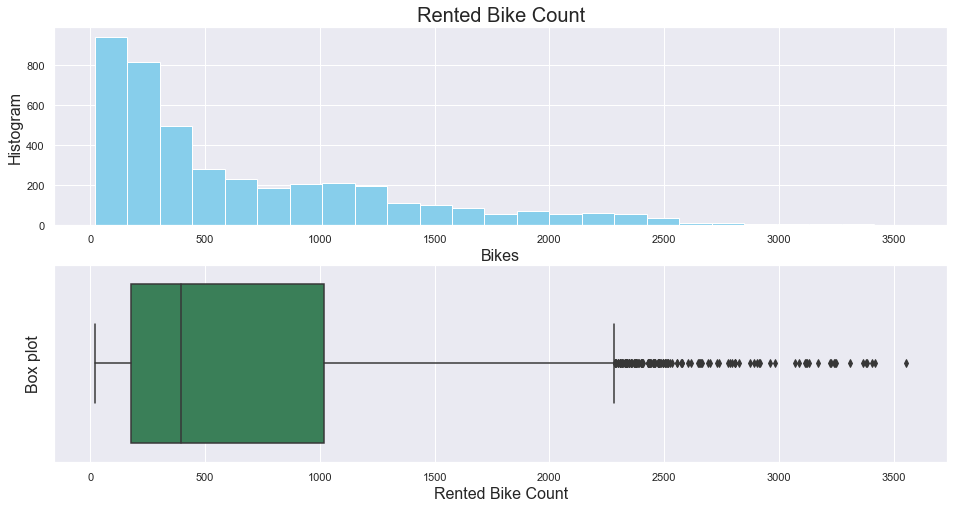

In [3]:
# Step 2: Histogram and box plot of "Rented Bike Count"
plt.subplot(211)
plt.title('Rented Bike Count', fontsize=20)
plt.hist(BikeData['Rented Bike Count'],bins=25,color='skyblue')
plt.xlabel('Bikes',fontsize=16)
plt.ylabel('Histogram',fontsize=16)

plt.subplot(212)
sns.boxplot(x=BikeData['Rented Bike Count'], color='seagreen')
plt.ylabel('Box plot', fontsize=16)
plt.xlabel('Rented Bike Count', fontsize=16)
plt.show()

From the previous two figures, we can get verify our initial intuition regarding bike rentals, which seem to have a significant variability.

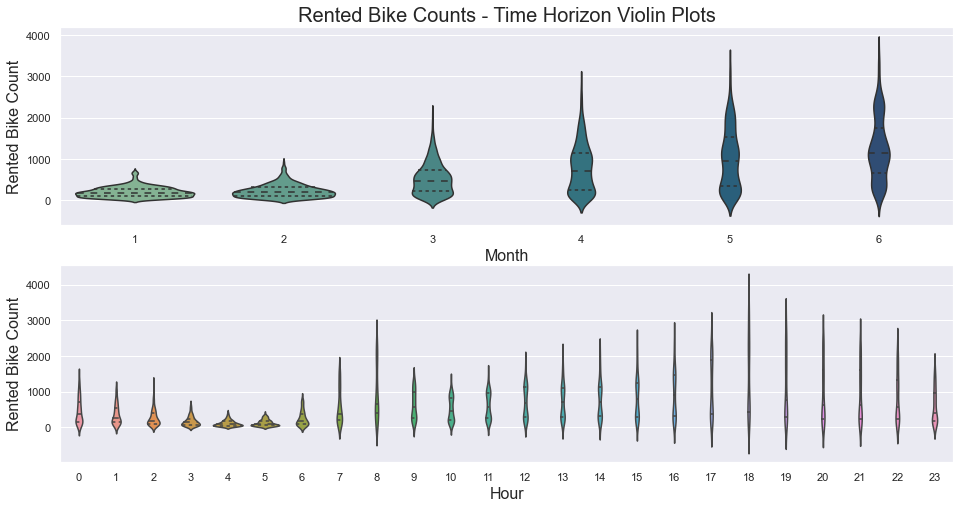

In [4]:
# Step 3: Violin plots
# Subplots
plt.subplot(211)
sns.violinplot(x='Month',y='Rented Bike Count',data=BikeData,inner='quartile')
plt.title('Rented Bike Counts - Time Horizon Violin Plots',fontsize=20)
plt.ylabel('Rented Bike Count', fontsize=16)
plt.xlabel('Month', fontsize=16)

plt.subplot(212)
sns.violinplot(x='Hour', y='Rented Bike Count', data=BikeData, inner='quartile')
plt.ylabel('Rented Bike Count', fontsize=16)
plt.xlabel('Hour', fontsize=16)
plt.show()

Finally, from our violin plots, which allow us to analyse the distributions of groups of our data, in the first violin plot we investigate distribution of **Rented Bike Count**, just as we did in our histogram, but now grouping our data by months (with 1 corresponding to January, 2 to February, etc.), and in our second violin plot, we explore again the distribution of **Rented Bike Count** but now grouping our data by hours. Our main insight from this figure is that the high bike demand variability displayed in our histogram and box plot is arising from our May and June demand, as well as from the demand from hours 15 to 22.

Next, we will focus on adjusting two models to our data, which we do to predict bike demand later.

-------------

## Data Pre-processing

The next cell deals with the important task of data pre-processing, specifically, we prepare our **Design Matrix** and **Target** data, as well as do scaling on our **Design Matrix** and create training and testing partitions of our **Design Matrix** and **Target** data.

In [5]:
# Step 4: Separate Desing Matrix and Target
DesingMatrix = BikeData.drop(['Rented Bike Count'],axis=1)
Target = BikeData['Rented Bike Count']

# Step 5: Perform test-train
X_train, X_test, y_train, y_test = train_test_split(DesingMatrix, Target, test_size=0.25, random_state=rnd_seed)

# Scaling the data with the Standar Scaler 
scaler = preprocessing.StandardScaler()
scaler.fit(X_train)
X_train_scaled = pd.DataFrame(scaler.transform(X_train),index=X_train.index,columns=X_train.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test),index=X_test.index,columns=X_test.columns)

With our data ready, we proceed to fit some models to our processed data and extract some key metrics to measure performance on both test set and training set.

---------
## Data modelling: Linear Regression

We now fit our first model to the data, namely **Linear Regression**, a comprehensive short guide on **Linear Regression** and some examples can be found in [2].

We will make use of three performance statistics $R^{2}$, RMSE and MAE. Explained next:
<br>
<br>$R^{2}$, also known as *Coefficient of Determination*, measures the proportion of the variance of our **Target** variable explained by the variables in our **Design Matrix**.
<br>**RMSE**, or *Root Mean Square Error*, is the standard deviation of the residuals (that is, the distance between our predicted **Target** values and the observed **Target** values.
<br>**MAE**, or *Mean Absolute Error*, is the mean of the absolute residuals.

In [6]:
# Step 6: Create and Fit a linear Regressor
# Create linear regression object
regr = linear_model.LinearRegression()

# Train the model using the training sets
regr.fit(X_train_scaled, y_train)

# Make predictions using the testing set
y_pred = regr.predict(X_test_scaled)
y_pred_train = regr.predict(X_train_scaled)

LR_Metrics = {}
# Metrics of Testing Set vs Predictions
LR_Metrics['R2_Test'] = skmetrics.r2_score(y_test, y_pred)
LR_Metrics['MAE_Test'] = skmetrics.mean_absolute_error(y_test, y_pred)
LR_Metrics['RMSE_Test'] = skmetrics.mean_squared_error(y_test, y_pred,squared=False)

LR_pred = y_pred

# Metrics of Training Set vs Predictions
LR_Metrics['R2_Train'] = skmetrics.r2_score(y_train, y_pred_train)
LR_Metrics['MAE_Train'] = skmetrics.mean_absolute_error(y_train, y_pred_train)
LR_Metrics['RMSE_Train'] = skmetrics.mean_squared_error(y_train, y_pred_train,squared=False)

print('Key Linear Regression Metrics')
print('------------------------------------------------')
print('     R2 Test Data: ',round(LR_Metrics['R2_Test'],2))
print('     R.M.S.E Test Data: ',round(LR_Metrics['RMSE_Test'],2))
print('     M.A.E. Test Data: ',round(LR_Metrics['MAE_Test'],2))
print('------------------------------------------------')
print('     R2 Training Data: ',round(LR_Metrics['R2_Train'],2))
print('     R.M.S.E Training Data: ',round(LR_Metrics['RMSE_Train'],2))
print('     M.A.E. Training Data: ',round(LR_Metrics['MAE_Train'],2))
print('------------------------------------------------')

Key Linear Regression Metrics
------------------------------------------------
     R2 Test Data:  0.63
     R.M.S.E Test Data:  388.58
     M.A.E. Test Data:  288.06
------------------------------------------------
     R2 Training Data:  0.61
     R.M.S.E Training Data:  409.9
     M.A.E. Training Data:  304.0
------------------------------------------------


From those key metrics, we can see that the results obtained are very similar to the ones presented on table 4 of Sathishkumar et al. [1], with slight difference due to the time frame considered in our project, which is set to 6 months of data.

Next, we visualize the behaviour of our predictions compared to our test data.

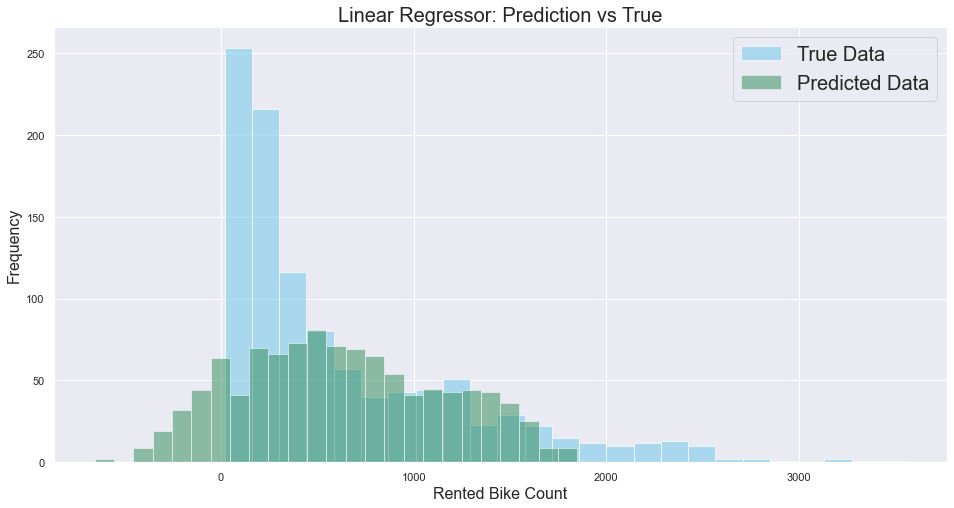

In [7]:
# Model plots
# Test vs prediction histogram
plt.title('Linear Regressor: Prediction vs True', fontsize=20)
plt.hist(y_test, alpha=0.65, bins=25, label='True Data', color='skyblue')
plt.hist(y_pred, alpha=0.50, bins=25, label='Predicted Data', color='seagreen')
plt.legend(loc='upper right', fontsize=20)
plt.xlabel('Rented Bike Count', fontsize=16)
plt.ylabel('Frequency', fontsize=16)
plt.show()

In this histogram, we can see how our model performs compared to the observed **Target** values, quickly, we can see that our model gets a good preditcion with the exception of the most likely values of our Test Data, so there is still room for improvement.

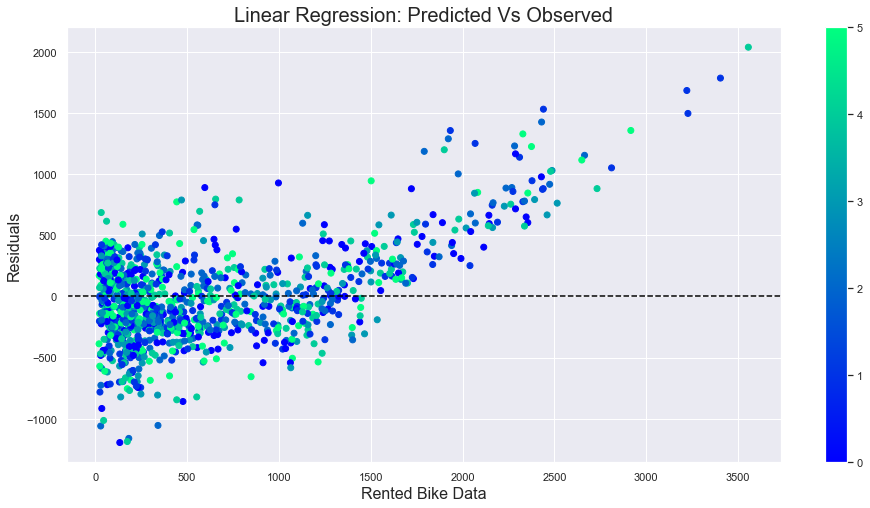

In [8]:
# Test vs prediction scatter plot
plt.title('Linear Regression: Predicted Vs Observed', fontsize=20)
sc = plt.scatter(y_test, y_test-y_pred, c=X_test.Month.astype('category').cat.codes[::-1])
plt.colorbar(sc)
plt.axhline(0.0, linestyle='--',color='black')
plt.xlabel('Rented Bike Data', fontsize=16)
plt.ylabel('Residuals', fontsize=16)
plt.winter()
plt.show()

Here, we see the residuals for our Linear Regression, with a colour associated to each month of data, with 0 being January, 1 being February, etc.

---------
## Data modelling: Support Vector Regression

We now fit our first model to the data, namely **Support Vector Regression**, a comprehensive short guide on **Support Vector Regression** and some examples can be found in [3].

Before actually fitting the model to our data, we have to deal with the computationally expensive task of hyperparameter tunning.

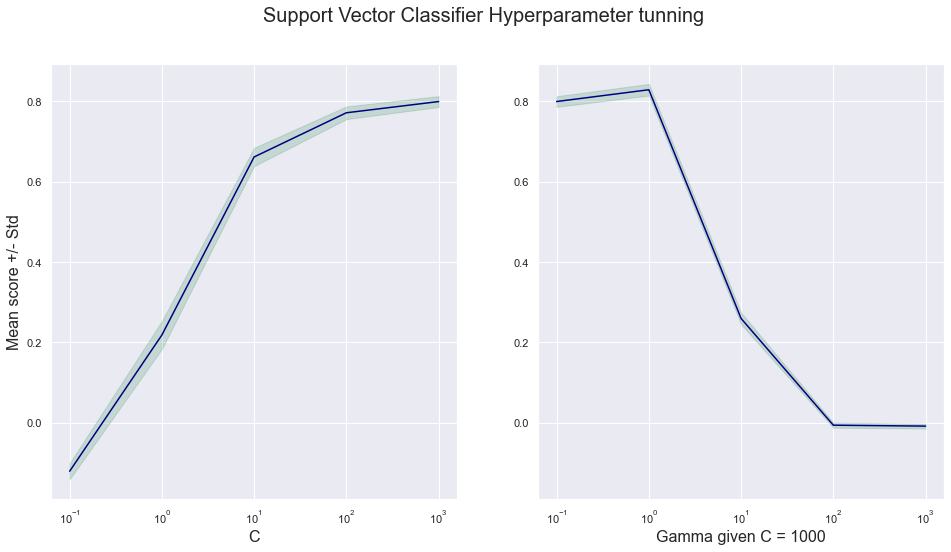

In [9]:
## Step 6.5: Hyperparameters optimization
# "C" hyperparameter tuning
from sklearn.model_selection import cross_val_score
fig = plt.figure()
fig.suptitle('Support Vector Classifier Hyperparameter tunning',fontsize=20)
ax1 = plt.subplot(121)
ax2 = plt.subplot(122)

C_vals = [0.1, 1, 10, 100, 1000]
Ncases = len(C_vals)
score_mean = np.zeros(Ncases)
score_std = np.zeros(Ncases)
for k in range(Ncases):
    clf = svm.SVR(C=C_vals[k])
    scores = cross_val_score(clf,X_train_scaled,y_train)  
    score_mean[k] = scores.mean()
    score_std[k] = scores.std()

ax1.semilogx(C_vals,score_mean,color='navy')
ax1.fill_between(C_vals,score_mean-score_std,score_mean+score_std,alpha=0.2,color='seagreen')
ax1.set_ylabel("Mean score +/- Std", fontsize="16")
ax1.set_xlabel("C", fontsize="16")

g_vals = [0.1, 1, 10, 100, 1000]
Ncases = len(g_vals)
score_mean = np.zeros(Ncases)
score_std = np.zeros(Ncases)
for k in range(Ncases):
    clf = svm.SVR(C=1000,gamma=g_vals[k])
    scores = cross_val_score(clf,X_train_scaled,y_train)
    score_mean[k] = scores.mean()
    score_std[k] = scores.std()

ax2.semilogx(g_vals,score_mean,color='navy')
ax2.fill_between(g_vals,score_mean-score_std,score_mean+score_std,alpha=0.2,color='seagreen')
ax2.set_xlabel("Gamma given C = 1000", fontsize="16")

ax1.get_shared_y_axes().join(ax1, ax2)
plt.subplots_adjust(hspace=0.001)
ax2.autoscale()
plt.show()

Once we find our hyperparameters, which in this case we choose to be C = 1000 and Gamma = 1, we turn our attention to the fitting, which again, we will measure its performance with the metrics discussed before.

In [10]:
#Step 7: Create and fit a Support Vector Machine
clf = svm.SVR(C = 1000, gamma = 1, kernel='rbf')

# Train the model, aka learn from the data
clf.fit(X_train_scaled, y_train)

# Predict the value of y for any unseen example.
y_pred = clf.predict(X_test_scaled)
y_pred_train = clf.predict(X_train_scaled)

SVR_Metrics = {}
# Metrics of Testing Set vs Predictions
SVR_Metrics['R2_Test'] = skmetrics.r2_score(y_test, y_pred)
SVR_Metrics['MAE_Test'] = skmetrics.mean_absolute_error(y_test, y_pred)
SVR_Metrics['RMSE_Test'] = skmetrics.mean_squared_error(y_test, y_pred,squared=False)

SVR_pred = y_pred

# Metrics of Training Set vs Predictions
SVR_Metrics['R2_Train'] = skmetrics.r2_score(y_train, y_pred_train)
SVR_Metrics['MAE_Train'] = skmetrics.mean_absolute_error(y_train, y_pred_train)
SVR_Metrics['RMSE_Train'] = skmetrics.mean_squared_error(y_train, y_pred_train,squared=False)

print('Key Support Vector Regressor Metrics')
print('------------------------------------------------')
print('     R2 Test Data: ',round(SVR_Metrics['R2_Test'],2))
print('     R.M.S.E Test Data: ',round(SVR_Metrics['RMSE_Test'],2))
print('     M.A.E. Test Data: ',round(SVR_Metrics['MAE_Test'],2))
print('------------------------------------------------')
print('     R2 Training Data: ',round(SVR_Metrics['R2_Train'],2))
print('     R.M.S.E Training Data: ',round(SVR_Metrics['RMSE_Train'],2))
print('     M.A.E. Training Data: ',round(SVR_Metrics['MAE_Train'],2))
print('------------------------------------------------')

Key Support Vector Regressor Metrics
------------------------------------------------
     R2 Test Data:  0.86
     R.M.S.E Test Data:  236.68
     M.A.E. Test Data:  143.35
------------------------------------------------
     R2 Training Data:  0.94
     R.M.S.E Training Data:  155.79
     M.A.E. Training Data:  58.45
------------------------------------------------


From those key metrics, once again, we can see that the results obtained are very similar to the ones presented on table 4 of Sathishkumar et al. [1], with slight difference due to the time frame considered in our project, which is set to 6 months of data.

Next, we visualize the behaviour of our predictions compared to our test data.

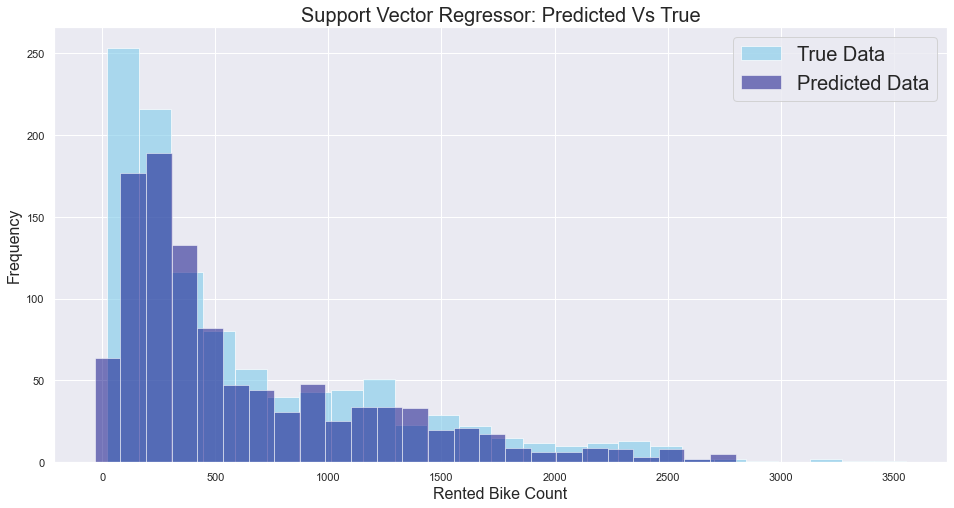

In [11]:
# Model plots
# Test vs prediction histogram
plt.title('Support Vector Regressor: Predicted Vs True', fontsize=20)
plt.hist(y_test, alpha=0.65, bins=25, label='True Data', color='skyblue')
plt.hist(y_pred, alpha=0.50, bins=25, label='Predicted Data', color='navy')
plt.legend(loc='upper right', fontsize=20)
plt.xlabel('Rented Bike Count', fontsize=16)
plt.ylabel('Frequency', fontsize=16)
plt.show()

In this histogram, we can see that the **Support Vector Regression** model does a much better job at predicting compared to our **Linear Regression** model, also observed in our $R^{2}$ metric.

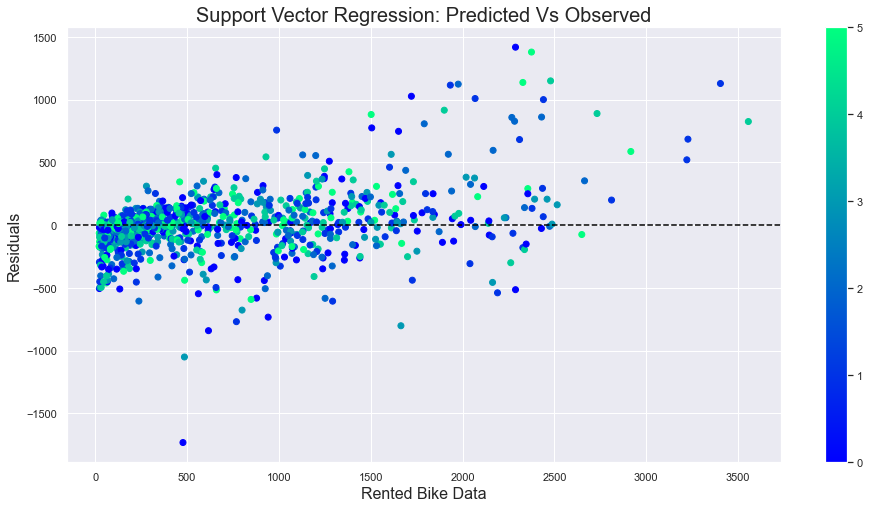

In [12]:
# Test vs prediction scatter plot
plt.title('Support Vector Regression: Predicted Vs Observed', fontsize=20)
cmap = X_test.Month.astype('category').cat.codes[::-1]
sc = plt.scatter(y_test, y_test-y_pred, c=cmap)
plt.axhline(0.0, linestyle='--',color='black')
plt.xlabel('Rented Bike Data', fontsize=16)
plt.ylabel('Residuals', fontsize=16)
cbar = plt.colorbar(sc)
plt.winter()
plt.show()

Here, we see the residuals for our Linear Regression, with a color associated to each month of data, with 0 being January, 1 being February, etc. Agian, we see an improvement compared to the **Linear Regression** model since the values are close to zero now (also observable in our RMSE and MAE metrics)

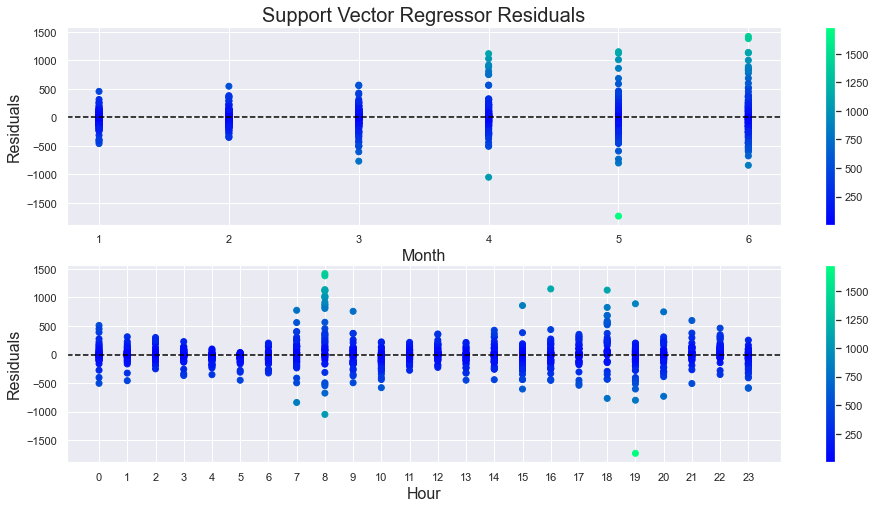

In [13]:
# Scatter plots
plt.subplot(211)
plt.title('Support Vector Regressor Residuals', fontsize=20)
sc = plt.scatter(X_test.Month, y_test-y_pred, c=(y_test-y_pred).abs())
plt.colorbar(sc)
plt.axhline(0.0, linestyle='--',color='black')
plt.xlabel('Month', fontsize=16)
plt.ylabel('Residuals', fontsize=16)
plt.winter()

plt.subplot(212)
sc = plt.scatter(X_test.Hour, y_test-y_pred, c=(y_test-y_pred).abs())
plt.colorbar(sc)
plt.axhline(0.0, linestyle='--',color='black')
plt.xticks(np.arange(min(X_test.Hour), max(X_test.Hour)+1, 1.0))
plt.xlabel('Hour', fontsize=16)
plt.ylabel('Residuals', fontsize=16)
plt.winter()
plt.show()

Finally, we analyse our Support Vector Regressor residuals as a function of months and hours, including a dashed line in the ideal 0 residual case and a colour map, with darker colours representing lower residuals.

Here we spot two things in our model residuals:

They mostly come from April, May, and June in terms of months (which can be intuitively explained since those months make the use of bikes more suitable due to warmer temperatures relative to January, February, and March), our model struggle here indicates that it is having problems picking up demand spikes in our observations.

In terms of hours, we again see a pattern, 7 a.m. to 9 a.m. and 6 p.m. Which makes intuitive sense since those are the times at which the population is either moving towards their activities or returning home in mort of the urban cities. Once our model struggle here indicates that it is having problems picking up demand spikes in our observations.

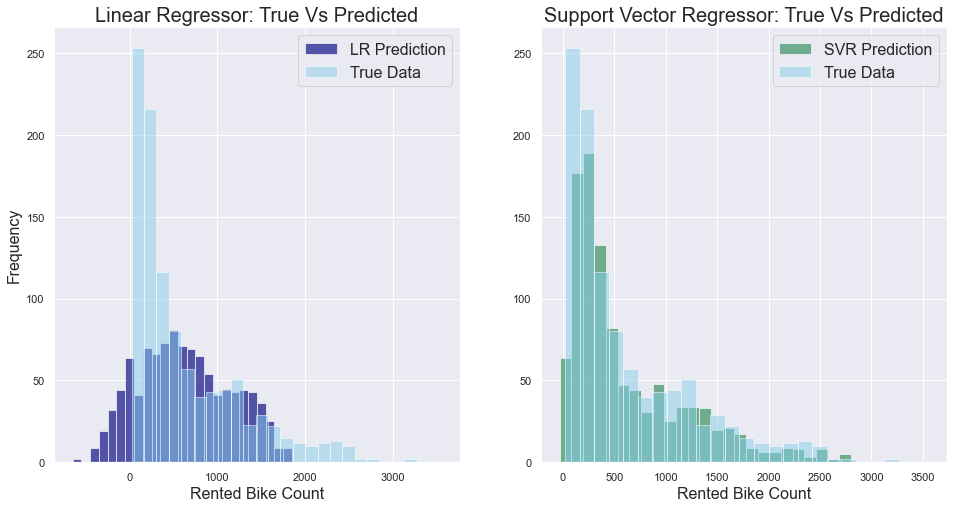

In [14]:
# Model plots
# Test vs prediction histogram
fig = plt.figure()
ax1 = plt.subplot(121)
ax2 = plt.subplot(122)
ax1.hist(LR_pred, alpha=0.65, bins=25, label='LR Prediction', color='navy')
ax1.hist(y_test, alpha=0.50, bins=25, label='True Data', color='skyblue')
ax1.set_title('Linear Regressor: True Vs Predicted',fontsize=20)
ax1.set_ylabel("Frequency", fontsize="16")
ax1.set_xlabel("Rented Bike Count", fontsize="16")
ax2.hist(SVR_pred, alpha=0.65, bins=25, label='SVR Prediction', color='seagreen')
ax2.hist(y_test, alpha=0.50, bins=25, label='True Data', color='skyblue')
ax2.set_title('Support Vector Regressor: True Vs Predicted',fontsize=20)
ax2.set_xlabel("Rented Bike Count", fontsize="16")
ax1.get_shared_y_axes().join(ax1, ax2)
ax2.autoscale()
ax1.legend(loc='upper right', fontsize=16)
ax2.legend(loc='upper right', fontsize=16)
plt.show()

In conclusion, we can see that the Support Vector Regression model is doing a better job at prediction comparing against the Linear Regression model by looking at the previous histogram.

-----------

## References

[1]: Sathishkumar V E, Jangwoo Park, and Yongyun Cho. ’Using data mining techniques for bike sharing demand prediction in
metropolitan city.’ Computer Communications, Vol.153, pp.353-366, March, 2020. https://doi.org/10.1016/j.comcom.2020.02.007.
<br>[2]: Scikit-Learn, Linear Regression, https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html, (accesed: 12/08/2021)
<br>[3]: Scikit-Learn, Support Vector Regression, https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVR.html, (accesed: 12/08/2021)